In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
df_pop = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--population_total--by--geo--time.csv')
df_pop.head(n=3)

,geo,time,population_total
0,afg,1800,3280000
1,afg,1801,3280000
2,afg,1802,3280000


In [4]:
df_gdp = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--gdppercapita_us_inflation_adjusted--by--geo--time.csv')
df_gdp.head(n=3)

,geo,time,gdppercapita_us_inflation_adjusted
0,abw,2010,24271.94042
1,afg,2002,364.57057
2,afg,2003,376.75871


In [5]:
df_life = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--life_expectancy_years--by--geo--time.csv')
df_life.head(n=3)

,geo,time,life_expectancy_years
0,abw,1800,34.42
1,abw,1801,34.42
2,abw,1802,34.42


In [6]:
df_child = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--datapoints--child_mortality_0_5_year_olds_dying_per_1000_born--by--geo--time.csv')
df_child.head(n=3)

,geo,time,child_mortality_0_5_year_olds_dying_per_1000_born
0,abw,1950,109.309
1,abw,1951,105.483
2,abw,1952,98.120


In [7]:
df_geo = pd.read_csv('dataset/ddf--gapminder--systema_globalis-master/ddf--entities--geo--country.csv')[['country', 'world_6region']]
df_geo = df_geo.rename(columns={'country': 'geo'})
df_geo.head(n=3)

,geo,world_6region
0,abkh,europe_central_asia
1,abw,america
2,afg,south_asia


In [8]:
df = df_pop.merge(df_gdp).merge(df_life).merge(df_child).merge(df_geo)
df.head(n=3)

,geo,time,population_total,gdppercapita_us_inflation_adjusted,life_expectancy_years,child_mortality_0_5_year_olds_dying_per_1000_born,world_6region
0,afg,2002,21979923,364.57057,52.43,122.2,south_asia
1,afg,2003,23064851,376.75871,53.03,118.3,south_asia
2,afg,2004,24118979,364.09544,53.50,114.4,south_asia


# correlation

In [9]:
import numpy as np
def weighted_corr(x, y, w):
    def weighted_mean(x, w):
        return np.sum(x*w) / np.sum(w)
    def weighted_cov(x, y, w):
        mean_x = weighted_mean(x, w)
        mean_y = weighted_mean(y, w)
        return np.sum(w * (x - mean_x) * (y - mean_y)) / np.sum(w)
    a = weighted_cov(x, y, w)
    b = weighted_cov(x, x, w)
    c = weighted_cov(y, y, w)
    return a / np.sqrt(b *c)

In [103]:
times = sorted(set(df.time))
regions = sorted(set(df.world_6region))

In [104]:
def plot_for(df, col_a, col_a_name, col_b, col_b_name):
    records = {region: [] for region in df.world_6region}
    for time in times:
        df_time = df[df.time == time]
        for region in regions:
            df_reg = df_time[df_time.world_6region == region]
            cor = weighted_corr(df_reg[col_a], df_reg[col_b], df_reg.population_total)
            records[region].append(cor)
    for region in regions:
        plt.plot(times, records[region])
    plt.title('Correlation between {} and {}'.format(col_a_name, col_b_name))
    plt.ylim(-1, 1)
    plt.legend(regions)

In [105]:
save_dir = Path('output')

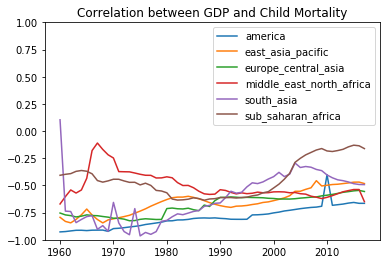

In [106]:
plot_for(df,
         'gdppercapita_us_inflation_adjusted', 'GDP',
         'child_mortality_0_5_year_olds_dying_per_1000_born', 'Child Mortality')
plt.savefig(save_dir / 'gdp_vs_child_mortality')

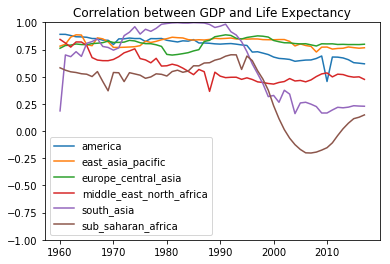

In [130]:
plot_for(df,
         'gdppercapita_us_inflation_adjusted', 'GDP',
         'life_expectancy_years', 'Life Expectancy')
plt.savefig(save_dir / 'gdp_vs_life_expectancy')

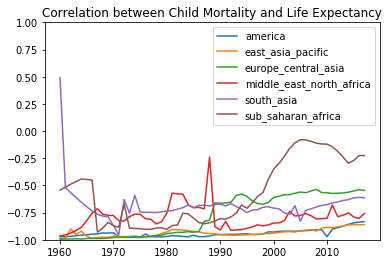

In [108]:
plot_for(df,
         'child_mortality_0_5_year_olds_dying_per_1000_born', 'Child Mortality',
         'life_expectancy_years', 'Life Expectancy')
plt.savefig(save_dir / 'child_mortality_vs_life_expectancy_years')

# supplemental plot

In [16]:
df['child_mortality_0_5_year_olds_dying'] = df['child_mortality_0_5_year_olds_dying_per_1000_born'] / 1000

In [17]:
def plot_for2(col, col_name):
    records = {region: [] for region in df.world_6region}
    for time in times:
        df_time = df[df.time == time].copy()
        df_time['tmp_total'] = df_time[col] * df_time['population_total']
        df_grouped = df_time.groupby('world_6region').sum()
        df_grouped['tmp_avg'] = df_grouped['tmp_total'] / df_grouped['population_total']
        for region in regions:
            records[region].append(df_grouped.loc[region]['tmp_avg'])
    for region in regions:
        plt.plot(times, records[region])
    plt.title('{}'.format(col_name))
    plt.legend(regions)

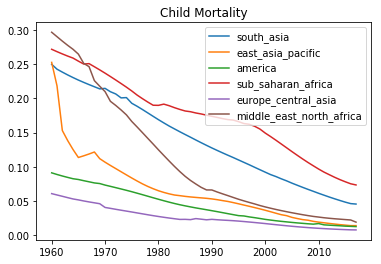

In [18]:
plot_for2('child_mortality_0_5_year_olds_dying', 'Child Mortality')
plt.savefig(save_dir / 'child_mortality')

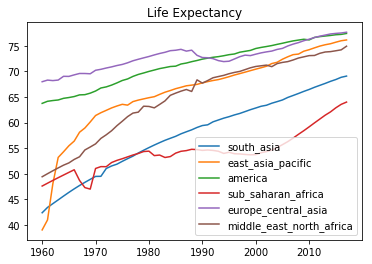

In [19]:
plot_for2('life_expectancy_years', 'Life Expectancy')
plt.savefig(save_dir / 'life_expectancy_years')

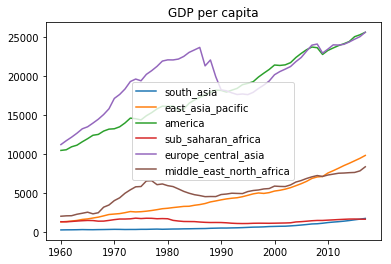

In [20]:
plot_for2('gdppercapita_us_inflation_adjusted', 'GDP per capita')
plt.savefig(save_dir / 'GDP')

# gif

In [139]:
import imageio
import os

In [156]:
def giftime(df, region, time, field1, field2, xlim, ylim, pop=1000000):
    df_time = df[df.time == time]
    df_reg = df_time[df_time.world_6region == region]
    plt.scatter(df_reg[field1], df_reg[field2], df_reg.population_total/pop, alpha=0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(field1)
    plt.ylabel(field2)
    plt.title('{} Year: {}'.format(region, time))

In [157]:
def gifrun(df, region, field1, field2, output, xlim, ylim):
    times = sorted(set(df.time))
    image_paths = ['dataset/gif_tmp/{}.png'.format(time) for time in times]
    for time, image_path in zip(times, image_paths):
        giftime(df, region, time, field1, field2, xlim, ylim, pop=1000000)
        plt.savefig(image_path)
        plt.close()
    images = [imageio.imread(image_path) for image_path in image_paths]
    imageio.mimsave(
        os.path.join('output', '{}.gif'.format(output)),
        images)

In [171]:
gifrun(df,
       'middle_east_north_africa',
       'gdppercapita_us_inflation_adjusted', 'child_mortality_0_5_year_olds_dying',
       'mena_gdp_child',
       (0, 50000), (0, 0.5))

![A](output/mena_life_child.gif)

In [170]:
gifrun(df,
       'south_asia',
       'gdppercapita_us_inflation_adjusted', 'child_mortality_0_5_year_olds_dying',
       'sa_gdp_child',
       (0, 6000), (0, 0.5))

![A](output/sa_life_child.gif)

In [159]:
gifrun(df,
       'sub_saharan_africa',
       'life_expectancy_years', 'child_mortality_0_5_year_olds_dying',
       'ssa_life_child',
       (40,80), (0, 0.5))

![A](output/ssa_life_child.gif)

In [160]:
gifrun(df,
       'sub_saharan_africa',
       'life_expectancy_years', 'gdppercapita_us_inflation_adjusted',
       'ssa_life_gdp',
       (40,80), (0, 10000))

![A](output/ssa_life_gdp.gif)

In [161]:
gifrun(df,
       'south_asia',
       'life_expectancy_years', 'gdppercapita_us_inflation_adjusted',
       'sa_life_gdp',
       (40,80), (0, 10000))

![A](output/sa_life_gdp.gif)

In [115]:
df_tmp = df[(df.time==1960) &
            (df.world_6region=='sub_saharan_africa') &
            (df.population_total>5000000)]
df_tmp.shape

(8, 8)

In [116]:
df_tmp.loc[df_tmp.gdppercapita_us_inflation_adjusted.idxmax()]

geo                                                                 zaf
time                                                               1960
population_total                                               17456855
gdppercapita_us_inflation_adjusted                              4527.25
life_expectancy_years                                             52.71
child_mortality_0_5_year_olds_dying_per_1000_born               182.987
world_6region                                        sub_saharan_africa
child_mortality_0_5_year_olds_dying                            0.182987
Name: 8279, dtype: object